In [179]:
from collections import defaultdict
import pyspark
from pyspark.sql import SparkSession
import pyspark.pandas as ps
from pyspark.sql.functions import split, col
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
from pyspark.ml.classification import LogisticRegression
from pyspark.sql.types import IntegerType, FloatType
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
import matplotlib.pyplot as plt

sc = (
    SparkSession
    .builder
    .master("local[2]")
    .appName("hw05")
    .getOrCreate()
)


In [201]:
dtrain = (
    sc
    .read
    .format("csv")
    .option("header",True)
    .option("quote", "\"")
    .option("escape", "\"")
    .option("multiline", True)
    .load("file:///home/jovyan/work/train.csv")
    .withColumn("toxic",col("toxic").cast("integer"))
    .withColumn("severe_toxic",col("severe_toxic").cast("integer"))
    .withColumn("obscene",col("obscene").cast("integer"))
    .withColumn("threat",col("threat").cast("integer"))
    .withColumn("insult",col("insult").cast("integer"))
    .withColumn("identity_hate",col("identity_hate").cast("integer"))
)


dtest = (
    sc
    .read
    .format("csv")
    .option("header",True)
    .option("quote", "\"")
    .option("escape", "\"")
    .option("multiline", True)
    .load("file:///home/jovyan/work/test.csv")
    # .withColumn("toxic",col("toxic").cast("integer"))
    # .withColumn("severe_toxic",col("severe_toxic").cast("integer"))
    # .withColumn("obscene",col("obscene").cast("integer"))
    # .withColumn("threat",col("threat").cast("integer"))
    # .withColumn("insult",col("insult").cast("integer"))
    # .withColumn("identity_hate",col("identity_hate").cast("integer"))
)

dlabels = (
    sc
    .read
    .format("csv")
    .option("header",True)
    .load("file:///home/jovyan/work/test_labels.csv")
    .withColumn("toxic",col("toxic").cast("integer"))
    .withColumn("severe_toxic",col("severe_toxic").cast("integer"))
    .withColumn("obscene",col("obscene").cast("integer"))
    .withColumn("threat",col("threat").cast("integer"))
    .withColumn("insult",col("insult").cast("integer"))
    .withColumn("identity_hate",col("identity_hate").cast("integer"))
)

dtest = dtest.join(dlabels, "id")

targets = [
    'toxic', 'severe_toxic', 'obscene',
    'threat', 'insult', 'identity_hate',
]

metrics = defaultdict(dict)
n_feats = 5
for n_feats in [5, 10, 20, 30, 50, 75, 100, 125, 150, 175, 200]:
    tokenizer = Tokenizer(inputCol="comment_text", outputCol="comment_words")
    dtrain2 = tokenizer.transform(dtrain)
    # 1) Подготовить фичи комментариев с помощью HashingTF и IDF
    hashingTF = HashingTF(inputCol="comment_words", outputCol="feats_raw", numFeatures=n_feats)
    dtrain2 = hashingTF.transform(dtrain2)
    idf = IDF(inputCol="feats_raw", outputCol="feats")
    idfModel = idf.fit(dtrain2)
    dtrain2 = idfModel.transform(dtrain2)
    
    # 2) Обучить линейные классификаторы и сравнить метрики качества моделей
    for target in targets:
        lr = LogisticRegression(labelCol=target).setFeaturesCol("feats")
        lrn = lr.fit(dtrain2)
        dtest2 = dtest[dtest[target]!=-1]#.show(10)
        dtest2 = tokenizer.transform(dtest2)
        dtest2 = hashingTF.transform(dtest2)
        dtest2 = idfModel.transform(dtest2)
        dtest2 = lrn.transform(dtest2)
        bce = BinaryClassificationEvaluator(labelCol=target)
        auroc = bce.evaluate(dtest2)
        # 3) Сделать выводы о влиянии параметра numFeatures в HashingTF на качество метрик
        metrics[target][n_feats] = auroc

In [202]:
metrics

defaultdict(dict,
            {'toxic': {5: 0.6550254920094833,
              10: 0.6609071429819509,
              20: 0.6805580630872279,
              30: 0.7054379058003177,
              50: 0.7023592610973597,
              75: 0.7427806588862823,
              100: 0.7588961337832818,
              125: 0.7775459119404801,
              150: 0.7730249869290667,
              175: 0.790478086726104,
              200: 0.7894934848427088},
             'severe_toxic': {5: 0.5554468776650233,
              10: 0.6323298195687617,
              20: 0.6550152607146377,
              30: 0.6325465661368112,
              50: 0.6982599277103055,
              75: 0.761472607881427,
              100: 0.7761570379431182,
              125: 0.7960010429536435,
              150: 0.8414787992942603,
              175: 0.7803246760784647,
              200: 0.8389306349727805},
             'obscene': {5: 0.6560260878384782,
              10: 0.6807442002889119,
              20: 0.6976978

max=0.790478086726104


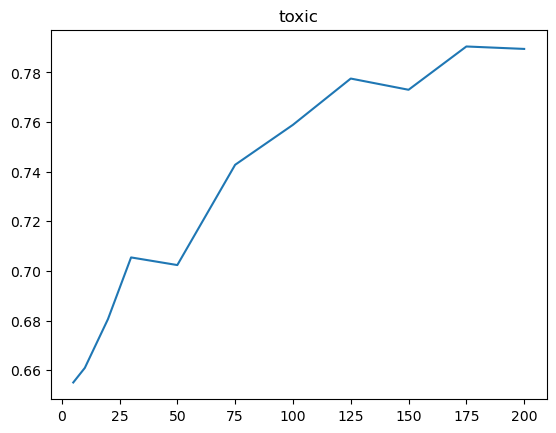

In [203]:
target = "toxic"
x,y = zip(*metrics[target].items())
plt.plot(x,y)
plt.title(target)
print(f"max={max(y)}")

max=0.8414787992942603


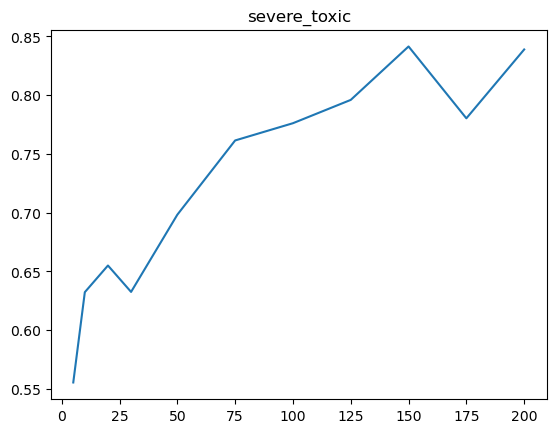

In [204]:
target = 'severe_toxic'# 'obscene', 'threat', 'insult', 'identity_hate',
x,y = zip(*metrics[target].items())
plt.plot(x,y)
plt.title(target)
print(f"max={max(y)}")

max=0.8203611127388105


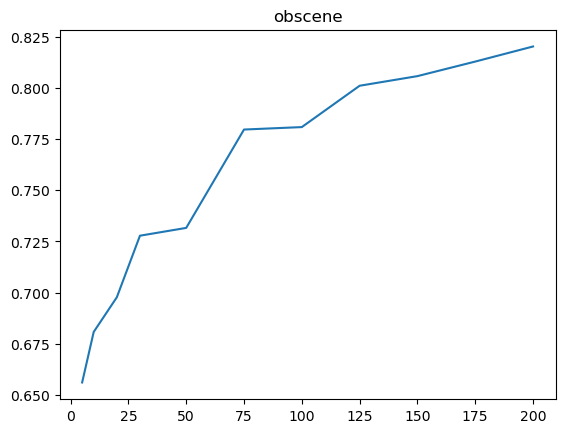

In [205]:
target = 'obscene'#, 'threat', 'insult', 'identity_hate',
x,y = zip(*metrics[target].items())
plt.plot(x,y)
plt.title(target)
print(f"max={max(y)}")

max=0.8659887146904885


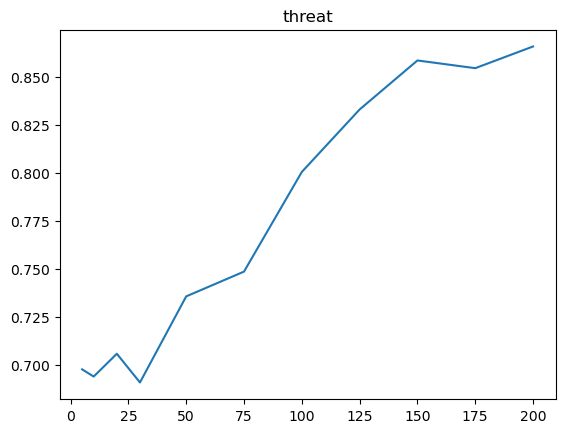

In [206]:
target = 'threat'#, 'insult', 'identity_hate',
x,y = zip(*metrics[target].items())
plt.plot(x,y)
plt.title(target)
print(f"max={max(y)}")

max=0.8159722346882557


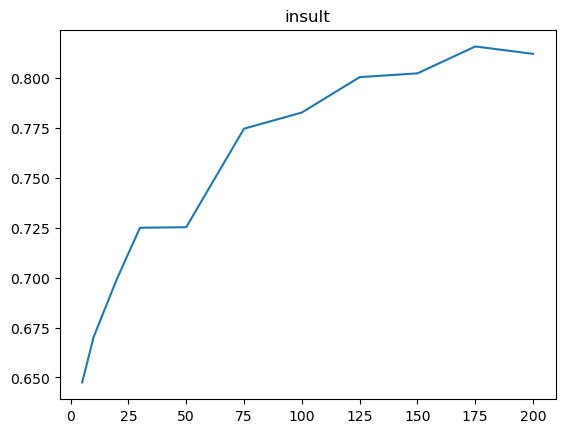

In [207]:
target = 'insult'#, 'identity_hate',
x,y = zip(*metrics[target].items())
plt.plot(x,y)
plt.title(target)
print(f"max={max(y)}")

max=0.7761001613661193


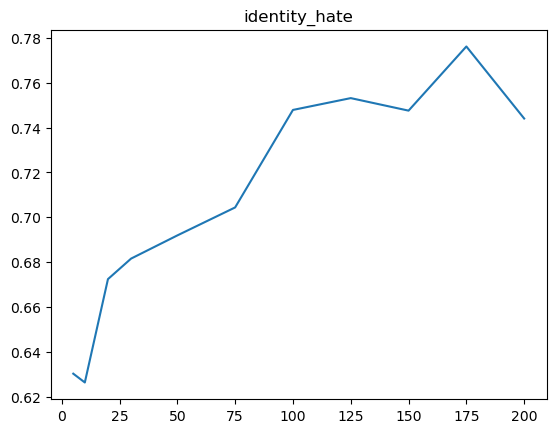

In [208]:
target = 'identity_hate'
x,y = zip(*metrics[target].items())
plt.plot(x,y)
plt.title(target)
print(f"max={max(y)}")

# Выводы
1. Для каждого таргета метрика AUROC растет с увеличением numFeatures пока не достигнет оптимального значения numFeatures, затем падает. 
2. У каждого таргета свое оптимальное значение numFeatures